In [1]:
import psycopg2
import requests
import nbimporter
import datetime
import sys
import copy
import operator
import numpy as np
import matplotlib.pyplot as plt
import Init_database as indb
import pdb
from calendar import monthrange
from googletrans import Translator
import warnings
warnings.filterwarnings("ignore")

Importing Jupyter notebook from Init_database.ipynb


In [132]:
sta_list = ['2b3a35d4-cb94-4b8f-a47a-bbb054754066', '1d02640a-7f14-4fc3-baaf-60754a38fff7',
            'ac6cb946-5fff-491b-859e-55cc5f701657', 'dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66',
            'b134a159-16bd-4f5d-af1b-cd42599a3bab', '33a3c031-0a3a-417d-ba1b-53549bb08dc2', 
            'e4758edb-1183-4c51-887b-a52ca7abef3d', '13bdab71-110b-4448-a3c4-5c3113183546']
interestOFStation = -3

In [133]:
db_name="db_teld"
user_name="postgres"
password = "ecalscraping"
host="169.229.157.40"
port="5432"
conn = indb.init_db(db_name, user_name, password, host, port)

In [134]:
#Request user activity from a station
try:
    cur = conn.cursor()
#     stmt = "select starttime, cartypename, usernickname, pilename from tbl_APP_useractivity where stationid in %s"
#     cur.execute(stmt, (tuple(sta_list),))
    stmt = "select starttime, cartypename, usernickname, pilename from tbl_APP_useractivity where stationid = '{}' \
    order by starttime".format(sta_list[interestOFStation])
    cur.execute(stmt)
    station_userAct = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print("Number of user activities: ", len(station_userAct))

('Number of user activities: ', 25)


# Visualization of User Activities

## Visualization of Frequncy

In [104]:
pilename_dict = dict()
for idx, act in enumerate(station_userAct):
    name = act[-1][:3]
    if name in pilename_dict:
        pilename_dict[name] += 1
    else:
        pilename_dict[name] = 1

Text(0.5,1,u'In Total of 25 Activities')

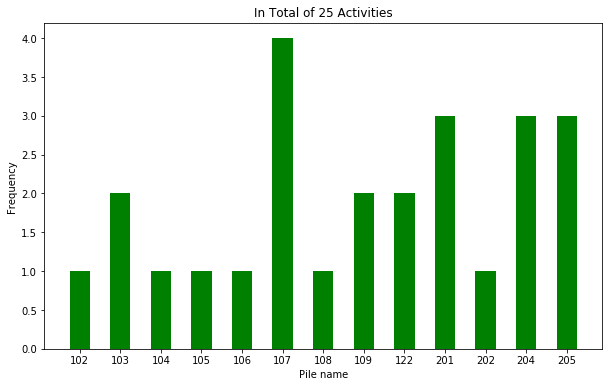

In [105]:
plt.figure(figsize=(10, 6))
plt.rc('font',size=10)
plt.bar(pilename_dict.keys(), pilename_dict.values(), width=0.5, color='g')
plt.xlabel("Pile name")
plt.ylabel("Frequency")
plt.title("In Total of {} Activities".format(len(station_userAct)))

In [106]:
def clean_stationAct(station_userAct):
    station_userAct_cleaned = []
    for idx, act in enumerate(station_userAct):
        if act[0].month < 6:
#             pdb.set_trace()
            date = act[0]
            date = date.replace(year=2018)
            station_userAct_cleaned.append((date,) + act[1:])
        else:
            station_userAct_cleaned.append(act)
    return station_userAct_cleaned

In [107]:
def extract_useful(station_userAct, interestOFyear, interestOFmon, interestOFday):
    thre_date = datetime.datetime(interestOFyear, interestOFmon, interestOFday, \
                                  tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-480, name=None))
    station_userAct_cleaned = []
    for i in range(len(station_userAct)):
        if station_userAct[i][0] > thre_date:
            station_userAct_cleaned.append(station_userAct[i])
    return station_userAct_cleaned

In [108]:
interestOFyear = 2018
interestOFmon = 2
interestOFday = 1
station_userAct = clean_stationAct(station_userAct)
station_userAct = extract_useful(station_userAct, interestOFyear, interestOFmon, interestOFday)

In [109]:
x_user = [(station_userAct[i][0], station_userAct[i][-1][:3]) for i in range(len(station_userAct))]
# x = [x[i].replace(year=2018) for i in range(len(x)) if (x[i].month < 6)] + \
# [x[i] for i in range(len(x)) if (x[i].month > 6)]
y_user = np.ones(len(x_user))

In [110]:
sum(y_user)

5.0

Text(0,0.5,u'Indicator of Usage')

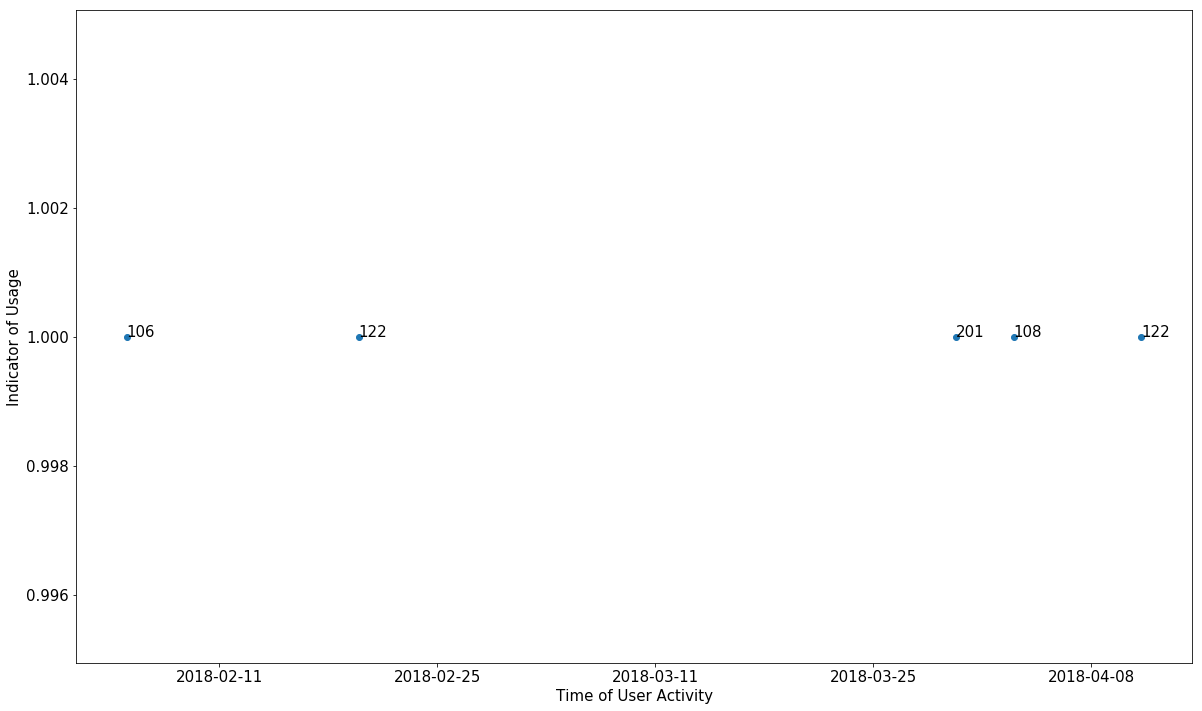

In [111]:
plt.figure(figsize=(20, 12))
plt.rc('font',size=15)
plt.scatter([x_user[i][0] for i in range(len(x_user))], y_user)
for idx in range(len(x_user)):
    plt.annotate(x_user[idx][1], (x_user[idx][0], y_user[idx]))
plt.xlabel("Time of User Activity")
plt.ylabel("Indicator of Usage")

# Visuliazation of Pile Utilization

In [112]:
try:
    cur = conn.cursor()
#     stmt = "select pilecode from tbl_APP_pilecode where staid in %s"
#     cur.execute(stmt, (tuple(sta_list),))
    stmt = "select pilecode from tbl_APP_pilecode where staid = '{}'".format(sta_list[1])
    cur.execute(stmt)
    pillcode_list = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print("Nubmer of pills: ", len(pillcode_list))

('Nubmer of pills: ', 8)


In [113]:
class Station(object):
    "This is a station object"
    num_pills = 0
    def __init__(self, stationid, score, pricescore, servicescore, 
                 stationname, stationaddress, location):
        self.id = stationid
        self.score = score
        self.pricescore = pricescore
        self.servicescore = servicescore
        self.name = stationname
        self.addr = stationaddress
        self.GPS = location
        self.pills = []
        self.ult_data = []
    def add_Pill(self, pill_obj):
        self.pills.append(pill_obj)
        self.num_pills += 1
    def delete_numPills(self):
#         if self.pills >= 1:
#             self.pills -= 1
        pass
    def check_pill(self, pillcode):
        for pill in self.pills:
            #if exist return True
            if pill.pillcode == pillcode:
                return True
        return False
    def get_maxPower(self):
        maxPower = 0
        for pill in self.pills:
            if pill.isfast == "Y":
                maxPower += 60 #kw
            else:
                maxPower += 7 #kw
        return maxPower
    def get_stationName_Eng(self):
        translator = Translator()
        return translator.translate(self.name).text

In [114]:
class Pill(Station):
    ult_data = None
    def __init__(self, pillcode, voltage, description, isfast, chargingport, power, pricedesc, prices, station):
        self.pillcode = pillcode
        self.voltage = voltage
        self.description = description
        self.isfast = isfast
        self.chargingport = chargingport
        self.power = power
        self.pricedesc = pricedesc
        self.prices = prices
        self.station = station
    def update_ultData(self, ult_data_new):
        self.ult_data = ult_data_new

In [115]:
# #------- Request one pill daily utilization data from db -------#
def get_pill_daily(pillcode):
    try:
        cur = conn.cursor()
        stmt = "select statecodev3, statenamev3, time from tbl_APP_state where pillcode='{}' \
        order by time".format(pillcode)
        cur.execute(stmt)
        ult_data = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return ult_data

In [116]:
# #------- Request the pill details from db -------#
def get_pill_details(pillcode):
    try:
        cur = conn.cursor()
        stmt = "select voltage, description, isfast, chargingport, power, pricedesc, \
        prices from tbl_app_piles where pillcode='{}'".format(pillcode)
        cur.execute(stmt)
        pill_details = cur.fetchall()
        cur.close()
        return pill_details
    except psycopg2.Error as e:
        print(e)

In [117]:
# #------- Request the station details from db -------#
def get_sta_details(stationid):
    try:
        cur = conn.cursor()
        stmt = "select servicescore, score, pricescore, stationname, stationaddress, ST_X(location), \
        ST_Y(location) from tbl_app_eachstations where stationid='{}'".format(stationid)
        cur.execute(stmt)
        sta_details = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return sta_details

In [118]:
# #------- Request pillcodes from same station from db -------#
def get_pillcodes(stationid=sta_list[0]):
    try:
        cur = conn.cursor()
        stmt = "select pillcode from tbl_app_piles where staid='{}'".format(stationid)
        cur.execute(stmt)
        pillcode_list = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return pillcode_list

In [119]:
def get_pill_station_details(sta_list):
    pillcode_list = []
    pill_details_list = []
    sta_details_list = []
    for staid in sta_list:
        pillcode_list.append(get_pillcodes(staid))
        pill_details_list.append(get_pill_details(pillcode_list[0][0][0]))
        sta_details_list.append(get_sta_details(staid))
    return pillcode_list, pill_details_list, sta_details_list

In [120]:
def init_sta(stationid, score, pricescore, 
               servicescore, stationname, stationaddress, x, y):
    """
    Data cleansing + passing into Station object to initiate
    """
    location  = (x, y)
    station = Station(stationid, score, pricescore, servicescore, stationname, stationaddress, location)
    return station

In [121]:
def constr_pill(pillcode, voltage, description, isfast, 
                chargingport, power, pricedesc, prices, station):
    """
    Data cleansing + passing into Pill object to initiate
    """
    pill = Pill(pillcode, voltage, description, isfast, chargingport, power, pricedesc, prices, station)
    return pill

In [122]:
def constr_sta(pillcode_list, station):
    """
    Construct full station and pills included
    """
    for pillcode in pillcode_list:
        pill_details = get_pill_details(pillcode=pillcode[0])
        if not station.check_pill(pillcode[0]):
            pill = constr_pill(pillcode[0], pill_details[0][0], pill_details[0][1], pill_details[0][2],
                  pill_details[0][3], pill_details[0][4], pill_details[0][5], pill_details[0][6], station)
            station.add_Pill(pill)
    return station

In [123]:
def update_ultData(station):
    for pill in station.pills:
        pillcode = pill.pillcode
        ult_data = get_pill_daily(pillcode)
        pill.update_ultData(ult_data)
    return station

In [124]:
def init_station_obj(sta_list, sta_details_list):
    staObject_list = []
    for i, staid in enumerate(sta_list):
        station_obj = init_sta(staid, sta_details_list[i][0][0], sta_details_list[i][0][1], 
                               sta_details_list[i][0][2], sta_details_list[i][0][3], 
                               sta_details_list[i][0][4], sta_details_list[i][0][5], 
                               sta_details_list[i][0][6])
        staObject_list.append(station_obj)
    return staObject_list

In [125]:
def constr_station_objFull(staObject_list, pillcode_list):
    for i, pillcodes in enumerate(pillcode_list):
        staObject_list[i] = constr_sta(pillcodes, staObject_list[i])
    return staObject_list

In [126]:
def update_daily_ultData(staObject_list):
    """
        Takes in a list of station
        Returns a list if list length > 1, a station object if length = 0
    """
    if len(staObject_list) == 1:
        return update_ultData(staObject_list[0])
    else:
        for i in range(len(staObject_list)):
            staObject_list[i] = update_ultData(staObject_list[i])
        return staObject_list

In [135]:
#get the station related details
pillcode_list, pill_details, sta_details = get_pill_station_details([sta_list[interestOFStation]])

In [136]:
#Initialize the station
station_obj =init_sta(sta_list[interestOFStation], sta_details[0][0], sta_details[0][0][1], sta_details[0][0][2], 
                      sta_details[0][0][3], sta_details[0][0][4], sta_details[0][0][5], sta_details[0][0][6])

In [137]:
#Construct the full station
station_obj = constr_station_objFull([station_obj], pillcode_list)
station_obj = constr_sta(pillcode_list[0], station_obj[0])
##-----YinXing_IndustrialPark_sta is a station object now not a list.
print(station_obj.num_pills)

19


In [138]:
station_obj = update_daily_ultData([station_obj])
station_obj = update_ultData(station_obj)
print(station_obj.pills[0].ult_data[0])

('05', '\xe5\xb7\xb2\xe6\x8f\x92\xe6\x9e\xaa', datetime.datetime(2017, 9, 10, 23, 35, 34, 441082, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)))


In [83]:
x_pile = []
y_pile = []
interestOFyear = 2018
interestOFmon = 2
interestOFday = 1
for p in range(len(station_obj.pills)):
    for i in range(len(station_obj.pills[p].ult_data)):
        if station_obj.pills[p].ult_data[i][2] > \
        datetime.datetime(interestOFyear, interestOFmon, interestOFday, \
                          tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-480, name=None)) and \
        station_obj.pills[p].ult_data[i][0] == '02':
            x_pile.append((station_obj.pills[p].ult_data[i][2], station_obj.pills[p].pillcode[-3:]))
            y_pile.append(1)

Text(0,0.5,u'Indicator of Usage')

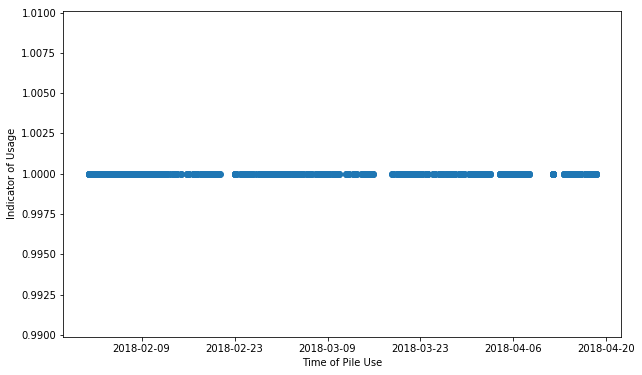

In [89]:
plt.figure(figsize=(10, 6))
plt.rc('font',size=10)
plt.scatter([x_pile[i][0] for i in range(len(x_pile))], y_pile)
plt.xlabel("Time of Pile Use")
plt.ylabel("Indicator of Usage")

# Superimposing user and pile utilization

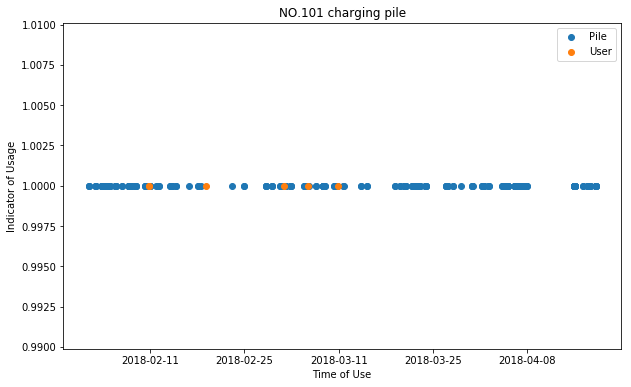

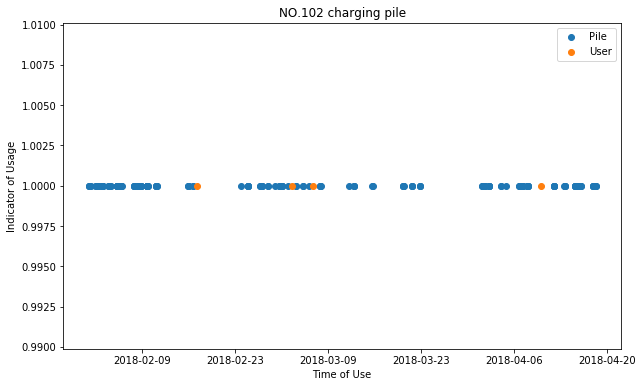

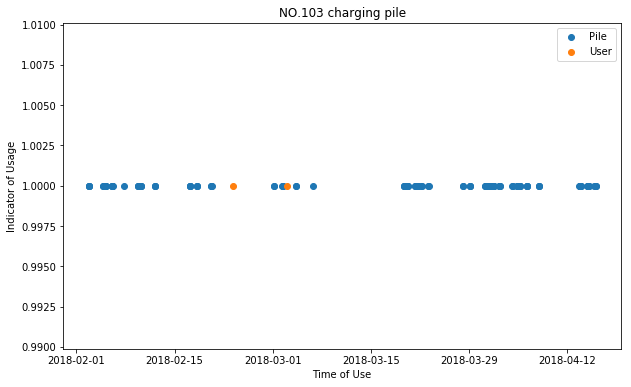

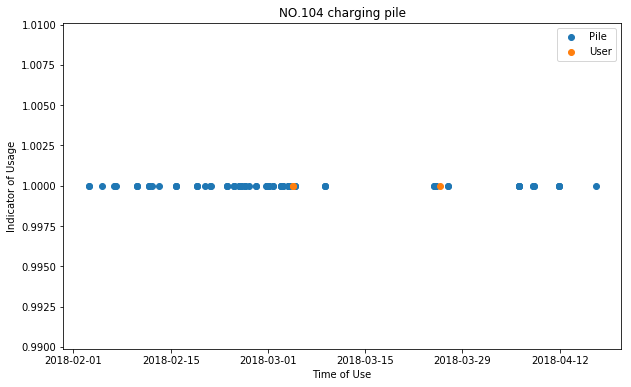

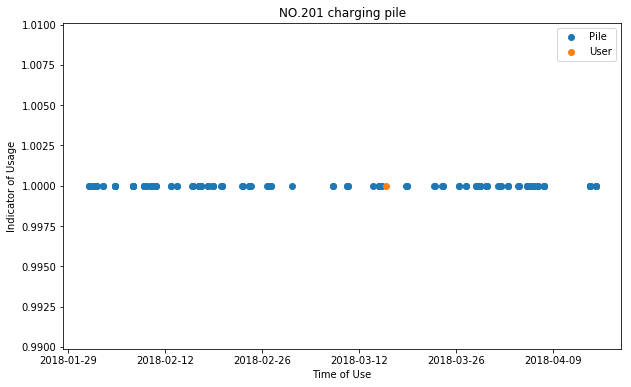

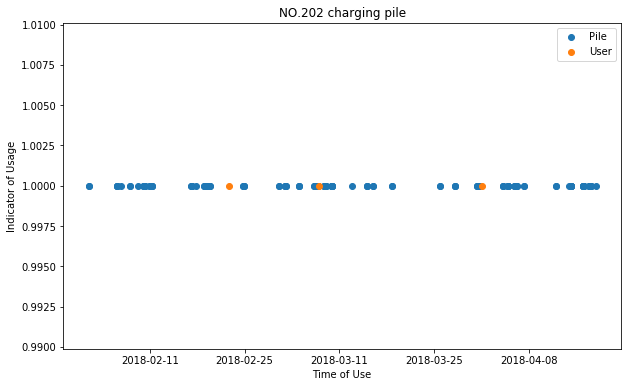

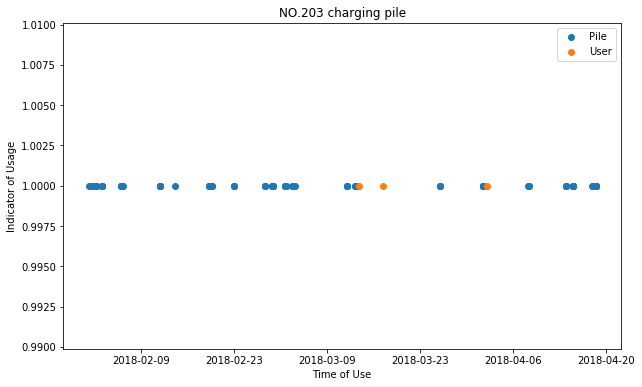

In [100]:
interestOFPile_list = np.unique([x_user[i][1] for i in range(len(x_user))])
for interestOFPile in interestOFPile_list:
    plt.figure(figsize=(10, 6))
    plt.rc('font',size=10)
    x_pile_interestOF = [x_pile[i][0] for i in range(len(x_pile)) if x_pile[i][1] == interestOFPile]
    x_user_interestOF = [x_user[i][0] for i in range(len(x_user)) if x_user[i][1] == interestOFPile]
    plt.scatter(x_pile_interestOF, np.ones(len(x_pile_interestOF)), label="Pile")
    plt.scatter(x_user_interestOF, np.ones(len(x_user_interestOF)), label="User")
    plt.xlabel("Time of Use")
    plt.ylabel("Indicator of Usage")
    plt.title("NO.{} charging pile".format(interestOFPile))
    plt.legend()
    plt.show()

In [96]:
len(np.unique([x_user[i][1] for i in range(len(x_user))]))

7